## Importing Dependencies

In [4]:
import os
import numpy as np

import cv2
import matplotlib.pylab as plt

import tensorflow as tf

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Loading Datasets

In [6]:
train_dir = 'imgdata_v2/split_dataset/train_aug/'
test_dir = 'imgdata_v2/split_dataset/test/'
val_dir = 'imgdata_v2/split_dataset/val/'

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=(256, 256))
val_dataset = tf.keras.utils.image_dataset_from_directory(val_dir, image_size=(256, 256))

Found 7051 files belonging to 2 classes.
Found 415 files belonging to 2 classes.


## Scaling Dataset

In [6]:
train_dataset.as_numpy_iterator().next()[0][0].max()

255.0

In [7]:
train_data = train_dataset.map(lambda x, y: (x/255, y))

In [8]:
train_data.as_numpy_iterator().next()[0][0].max()

1.0

In [9]:
val_data = val_dataset.map(lambda x, y: (x/255, y))

## CNN Model Architecture

In [115]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

model = Sequential()

model.add(Conv2D(16,(3,3), 3, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(8, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, kernel_regularizer=l2(0.004), activation='linear'))

model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.Hinge(), metrics=['accuracy'])
# model.summary()

In [12]:
logdir = 'LogDir'

try:
    os.mkdir(logdir)
except Exception as e:
    pass    

tfb_callback = tf.keras.callbacks.TensorBoard(logdir)

In [116]:
model_fit = model.fit(train_data, 
                      epochs=30, 
                      shuffle=True, 
                      validation_data=val_data, 
                      callbacks=[tfb_callback])

Epoch 1/30
221/221 [==============================] - 6s 22ms/step - loss: 0.7398 - accuracy: 0.6632 - val_loss: 0.7329 - val_accuracy: 0.5904
Epoch 2/30
221/221 [==============================] - 5s 20ms/step - loss: 0.3604 - accuracy: 0.8453 - val_loss: 0.3276 - val_accuracy: 0.8627
Epoch 3/30
221/221 [==============================] - 5s 20ms/step - loss: 0.2712 - accuracy: 0.8807 - val_loss: 0.2715 - val_accuracy: 0.8819
Epoch 4/30
221/221 [==============================] - 5s 20ms/step - loss: 0.2733 - accuracy: 0.8820 - val_loss: 0.2535 - val_accuracy: 0.8916
Epoch 5/30
221/221 [==============================] - 5s 20ms/step - loss: 0.2244 - accuracy: 0.9014 - val_loss: 0.2457 - val_accuracy: 0.8843
Epoch 6/30
221/221 [==============================] - 5s 20ms/step - loss: 0.2323 - accuracy: 0.8972 - val_loss: 0.2346 - val_accuracy: 0.8627
Epoch 7/30
221/221 [==============================] - 5s 20ms/step - loss: 0.2223 - accuracy: 0.9011 - val_loss: 0.2758 - val_accuracy: 0.8458

## Model Performance 

Text(0.5, 0.98, 'SVM Model Performance Curves')

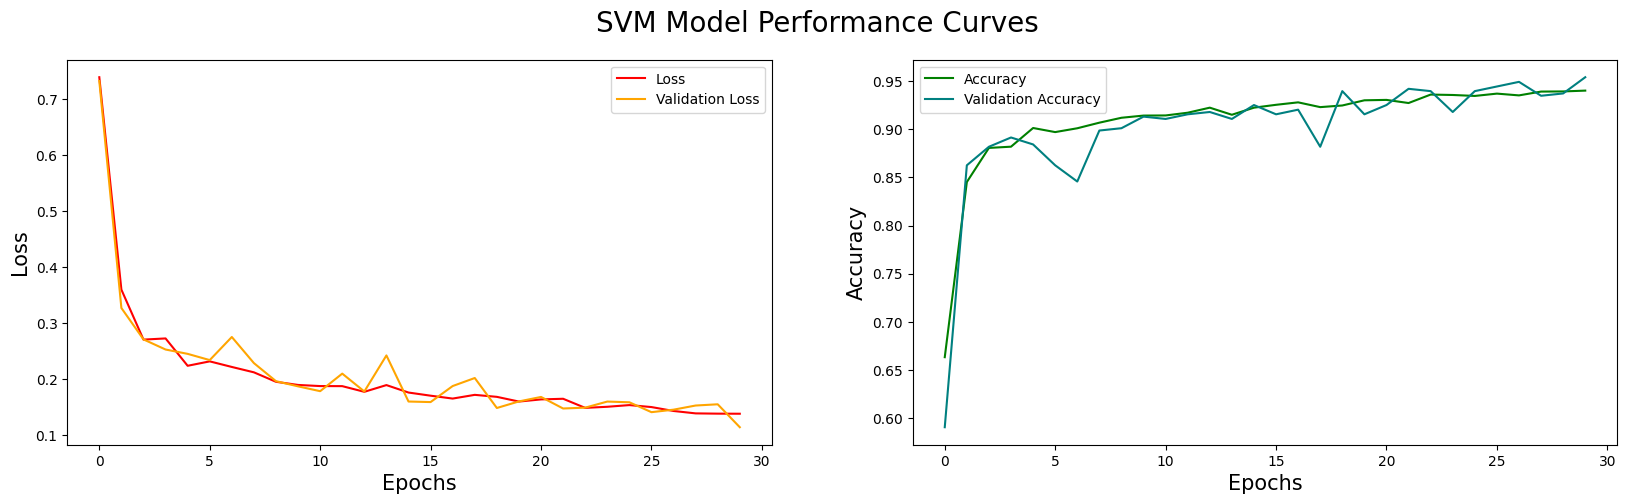

In [151]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))
axs[0].plot(model_fit.history['loss'], 
            color='red', 
            label='Loss')
axs[0].plot(model_fit.history['val_loss'], 
            color='orange', 
            label='Validation Loss')
axs[0].legend(loc='upper right')
axs[0].set_ylabel('Loss', fontsize=15)
axs[0].set_xlabel('Epochs', fontsize=15)

axs[1].plot(model_fit.history['accuracy'], 
             color='green', 
             label='Accuracy')
axs[1].plot(model_fit.history['val_accuracy'], 
             color='teal', 
             label='Validation Accuracy')
axs[1].legend(loc='upper left')
axs[1].set_ylabel('Accuracy', fontsize=15)
axs[1].set_xlabel('Epochs', fontsize=15)

fig.suptitle('SVM Model Performance Curves', fontsize=20)

## Exporting Model

In [2]:
from keras.models import save_model, load_model

# model.save(os.path.join('models_Reboot/','SVM_Re.h5'))

In [27]:
Model = load_model(os.path.join('models_Reboot/','SVM_Re.h5'))

In [28]:
Model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_77 (Conv2D)          (None, 85, 85, 16)        448       
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 42, 42, 16)       0         
 g2D)                                                            
                                                                 
 dropout_93 (Dropout)        (None, 42, 42, 16)        0         
                                                                 
 conv2d_78 (Conv2D)          (None, 40, 40, 16)        2320      
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 20, 20, 16)       0         
 g2D)                                                            
                                                                 
 dropout_94 (Dropout)        (None, 20, 20, 16)      

## Evaluating Model

In [29]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=(256, 256))

Found 210 files belonging to 2 classes.


In [30]:
test_data = test_dataset.map(lambda x, y : (x/255, y))

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
acc = BinaryAccuracy()
rec = Recall()

In [32]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred = Model.predict(X)
    
    acc.update_state(y, y_pred)
    pre.update_state(y, y_pred)
    rec.update_state(y, y_pred)

1/1 [==============================] - 0s 94ms/step


In [33]:
accuracy = acc.result().numpy()
precision = pre.result().numpy()
recall = rec.result().numpy()
f1 = 2 * (precision*recall) / (precision+recall)

print('Accuracy\t:', round(accuracy,5))
print('Precision\t:', round(precision,5))
print('Recall\t\t:', round(recall,5))
print('F1\t\t:', round(f1,5))

Accuracy	: 0.97143
Precision	: 0.97222
Recall		: 0.97222
F1		: 0.97222


1/1 [==============================] - 0s 42ms/step


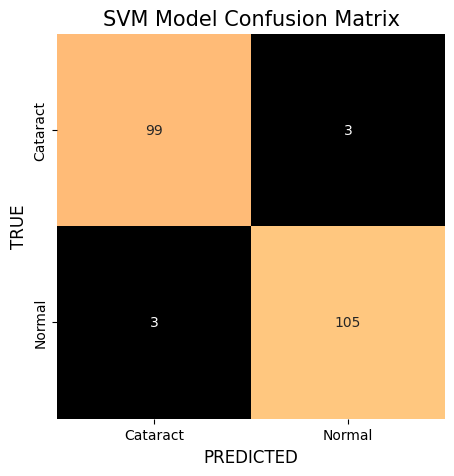

In [34]:
Y=[]
Y_pred=[]
for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred = Model.predict(X)
    y_pred = (y_pred > 0.5)
    Y.extend(y)
    Y_pred.extend(y_pred)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y, Y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='copper', cbar=False,
            xticklabels=['Cataract', 'Normal'], yticklabels=['Cataract', 'Normal'])
plt.xlabel('PREDICTED', fontsize=12)
plt.ylabel('TRUE', fontsize=12)
plt.title('SVM Model Confusion Matrix', fontsize=15)
plt.show()